# universal estimator

### Exp-1: Show that the error decreases when the parameter search space gets smaller.

Let $f(d)$ be a one dimensional function, that returns a samples vector drawn from a univariate distribution (e.g., log-normal).

1. Generate a (256) samples vector using e.g: data = f(d=0.92)
2. Write a function: exp_estimator(f, data) which learns the parameter d of f from the data.

> - Init: search_space = [0,1]
> - Iterate (stop condition: MAE < epsilon **or** size of the search-space (high-low) is 1/128 of the original)
>   1. Generate synthetic data-sets (train/test) using **f** (within param_search_space)
>   2. Fit a DNN model to train-set and predict on test-set, error = | pred-set - test-set |
>   3. Predict the parameter _d_ on the input _data_  (d_pred)
>   4. Narrow the search space:
>      - margin = 2 * std(error)
>      - search_space = [ d_pred - margin, d_pred  + margin]

3. Plot a graph:
   - x: size of search space (high-low)
   - y: MAE
   - show that the size of the error converges to a lower limit (asymptotically)

In [1]:
# import library
%run lib.ipynb
np.set_printoptions(precision=4)

In [2]:
def next_config(param_search_space):
    """
    return a random (uniform)parameter within param_search_space
    """
    low = param_search_space[0]
    high = param_search_space[1]
    if None != RS:
        return RS.uniform(low, high, size=1)[0]
    return np.random.uniform(low, high, size=1)[0]

def estimator_exp_1(f, data, d_true,
                    initial_param_search_space=np.array([0.0,1.0])):
    """
    Learn parameters of f, from the data.
    Arguments:
        - f: one dimensional function that gives the PMF of a univariate distribution.
        - data: samplesarray generated using f.
    """

    # experiment result: [ (size of search space, test_MAE) ]
    res = []
   
    # number of samples in data
    M = len(data)
    N = 1000

    d_pred_best = -1
    data_MAE_best = -1
    
    # Iterate
    param_search_space = initial_param_search_space
    while True:
        
        # 1. Generate synthetic learning data-sets (train/test) using f (within param_search_space)
        # -----------------------------------------------------------------------------------------
        print()
        print(f'generating data (M={M}, N={N}) param_search_space: {param_search_space} ...', end=' ')
        raw, H, params = generate_data(N=N, 
                                       M=M, 
                                       sample=f, 
                                       nextConfig=lambda: next_config(param_search_space),
                                       density=False, 
                                       apply_log_scale=False)

        H_train, H_test, train_params, test_params = train_test_split(H, 
                                                                      params, 
                                                                      test_size=0.25, 
                                                                      random_state=RANDOM_STATE)
        print(f'histogram shape: {H_train.shape}')

        # 2. Fit a DNN model to train-set and predict on test-set, error = | pred-set - test-set |
        # -----------------------------------------------------------------------------------------
        
        print(f'fitting dnn model ...', end=' ')
        start_time = time.time()
        dnn_model, history = dnn_fit(X_train=H_train, y_train=train_params)
        train_time = time.time() - start_time

        test_pred = dnn_model.predict(H_test).flatten()
        test_MAE = mean_absolute_error(test_params, test_pred)
        print(f'test_MAE: {test_MAE:.4f}', end=' ')

        # 3. Predict the parameter d on the input data (d_pred)
        # -----------------------------------------------------------------------------------------

        nbins = H_train.shape[1]
        h_data = np.histogram(data, bins=nbins, range=(0,nbins), density=False)[0]
        h_data = np.reshape(h_data, (1, -1))
        d_pred = dnn_model.predict(h_data).flatten()[0]
        print(f'd_pred: {d_pred:.4f}, abs(d_pred - d_true): {abs(d_pred - d_true):.4f}')
        
        #lilo
        data_pred = f(d_pred, size=M)
        data_MAE = mean_absolute_error(data_pred, data)
#         data_pred, _, _ = generate_data(N=100, test_STD_abs_error
#                                        M=M, 
#                                        sample=f, 
#                                        nextConfig=d_pred,
#                                        density=False, 
#                                        apply_log_scale=False)
#         repeat = 100
#         data_MAE = np.mean(mean_absolute_error(data_pred, np.repeat(data, repeat).reshape(repeat,-1)))
        print(f'data_MAE: {data_MAE:.4f}', end= ', ')
        if data_MAE_best < 0 or data_MAE < data_MAE_best:
            data_MAE_best = data_MAE
            d_pred_best = d_pred
        print(f'data_MAE_best: {data_MAE_best:.4f}', end= ', ')
        print(f'd_pred_best: {d_pred_best:.4f}')
        #print(f'abs(d_pred_best - d_true): {abs(d_pred_best - d_true):.4f}', end= ', ')
        
        # append to results: [param_search_space_width, MAE]
        param_search_space_width = param_search_space[1] - param_search_space[0]
        res.append((param_search_space_width, test_MAE, abs(d_pred - d_true), abs(d_pred_best - d_true)))
                
        # 4. Narrow the search space:
        # -----------------------------------------------------------------------------------------
        #  - margin = MAE + 2 * std(error)
        #  - search_space = [ d_pred - margin, d_pred + margin]
        
        #lilo:
        test_STD_abs_error = np.std( np.abs(test_params, test_pred) )
#         margin_std_factor = 1.5
        margin_std_factor = 2
        margin = margin_std_factor * test_STD_abs_error
        #margin = test_STD_abs_error
        
        #pivot = d_pred_best
        #print(f'pivot=d_pred_best: {pivot:.4f}, margin={margin_std_factor}*test_STD_abs_error: {margin:.4f}')
        pivot = d_pred
        print(f'pivot=d_pred: {pivot:.4f}, margin={margin_std_factor}*test_STD_abs_error: {margin:.4f}')
        
        next_search_space = np.array([ 
            max(param_search_space[0], pivot - margin), 
            min(param_search_space[1], pivot + margin)])
#         next_search_space = np.array([ 
#             max(initial_param_search_space[0], pivot - margin), 
#             min(initial_param_search_space[1], pivot + margin)])
        
        if np.array_equal(param_search_space, next_search_space):
            # if no change in param_search_space, narrow by epsilon (from both sides)
            #epsilon = 0.005
            #epsilon = test_STD_abs_error
            epsilon = 0.1 * test_STD_abs_error
            print(f'no change in param_search_space. narrowing by epsilon: {epsilon:.4f}')
            param_search_space = np.array([param_search_space[0] + epsilon, param_search_space[1] - epsilon])
        else:
            count_no_change_in_search_space = 0
            param_search_space = next_search_space
        
        # stop condition ?
        # size of the search-space (high-low) is 1/128 of the original
        # -----------------------------------------------------------------------------------------
        
        initial_param_search_space_width = initial_param_search_space[1] - initial_param_search_space[0]
#         if param_search_space_width < 1/128 * initial_param_search_space_width:
        if param_search_space_width < 1/16 * initial_param_search_space_width:
            print('stop -----------------------------------------------------------------')
            print(f'param_search_space_width: {param_search_space_width:.4f}')
            print(f'test_MAE: {test_MAE:.4f}')
            print(f'd_pred: {d_pred:.4f}, abs(d_pred - d_true): {abs(d_pred - d_true):.4f}')
            break
            
    return np.array(res)

## Fit (lognormal)

In [3]:
from scipy import stats
from scipy.stats import lognorm

# reset_random_state(SEED)

# sample from lognormal
def sample_lognormal(config, size):
    return lognorm.rvs(s=config, size=size, random_state=RANDOM_STATE)

# Fit (lognormal)
d_true = 0.92
# d_true = 0.85
# d_true = 0.66
# d_true = 0.25

print(f'param true value: {d_true}')
data = sample_lognormal(config=d_true, size=256)
res = estimator_exp_1(f=sample_lognormal, data=data, d_true=d_true)

param true value: 0.92

generating data (M=256, N=1000) param_search_space: [0. 1.] ... histogram shape: (750, 47)
fitting dnn model ... test_MAE: 0.0514 d_pred: 0.9682, abs(d_pred - d_true): 0.0482
data_MAE: 1.6594, data_MAE_best: 1.6594, d_pred_best: 0.9682
pivot=d_pred: 0.9682, margin=2*test_STD_abs_error: 0.5838

generating data (M=256, N=1000) param_search_space: [0.3844 1.    ] ... histogram shape: (750, 82)
fitting dnn model ... test_MAE: 0.0398 d_pred: 0.9253, abs(d_pred - d_true): 0.0053
data_MAE: 1.5095, data_MAE_best: 1.5095, d_pred_best: 0.9253
pivot=d_pred: 0.9253, margin=2*test_STD_abs_error: 0.3481

generating data (M=256, N=1000) param_search_space: [0.5773 1.    ] ... histogram shape: (750, 66)
fitting dnn model ... test_MAE: 0.0440 d_pred: 0.9525, abs(d_pred - d_true): 0.0325
data_MAE: 1.6332, data_MAE_best: 1.5095, d_pred_best: 0.9253
pivot=d_pred: 0.9525, margin=2*test_STD_abs_error: 0.2431

generating data (M=256, N=1000) param_search_space: [0.7094 1.    ] ... his

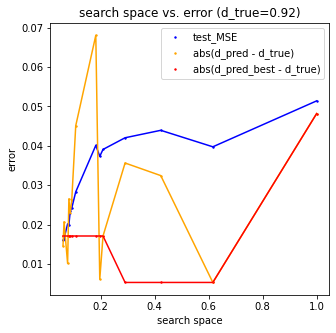

In [4]:
def plot_search_space_size_vs_MAE(res):
    plt.figure(figsize=(5,5))
    plt.title(f'search space vs. error (d_true={d_true})')
    plt.xlabel('search space')
    plt.ylabel('error')
    
    x = res[:, 0]
    y = res[:, 1]
    y_d_pred = res[:, 2]
    y_d_pred_best = res[:, 3]
    
    _ = plt.scatter(x, y, zorder=1, s=2, c='blue', label='test_MSE')
    _ = plt.plot(x, y, zorder=2, c='blue')

    _ = plt.scatter(x, y_d_pred, zorder=1, s=2, c='orange', label='abs(d_pred - d_true)')
    _ = plt.plot(x, y_d_pred, zorder=2, c='orange')
    
    _ = plt.scatter(x, y_d_pred_best, zorder=1, s=2, c='red', label='abs(d_pred_best - d_true)')
    _ = plt.plot(x, y_d_pred_best, zorder=2, c='red')
    
    plt.legend()   
plot_search_space_size_vs_MAE(res[0:,:])

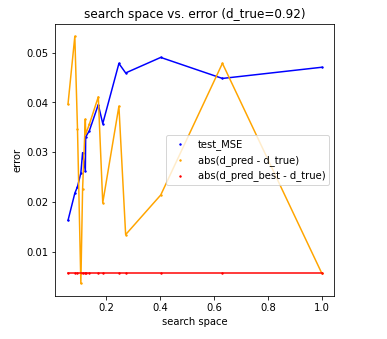
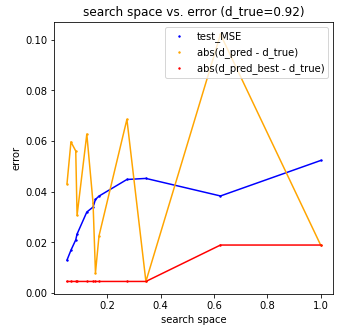
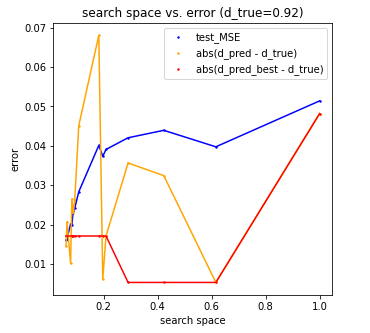

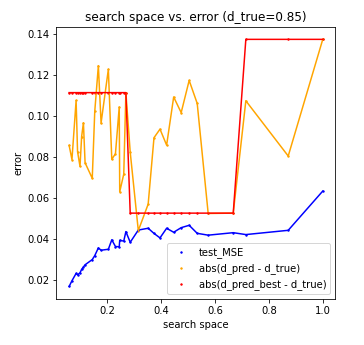

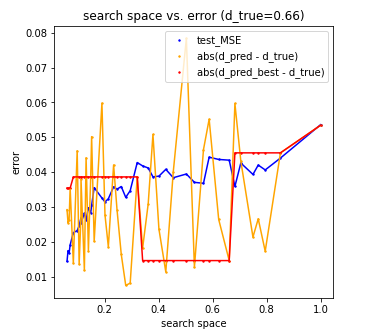

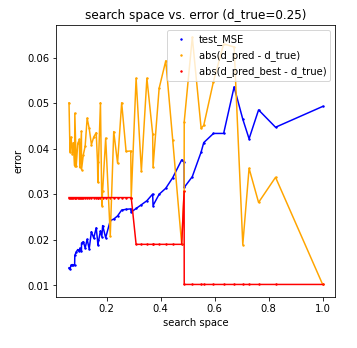
